In [ ]:
import sys
import numpy as np
from pyDOE import lhs
import torch
from torch import Tensor, ones, stack, load
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from scipy import stats
sys.path.insert(0,'/content/drive/MyDrive/NeuralSolvers-heat-eqn/examples/Research project')
from tesladatadiff4 import TeslaDatasetAll, TeslaDatasetSlice, TeslaDatasetpinn

sys.path.append("/content/drive/MyDrive/NeuralSolvers-heat-eqn") 
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [ ]:
# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def derivative(t, u):

    #u = u[:, 0]
    grads = ones(u.shape, device=u.device) # move to the same device as prediction
    grad_u = grad(u, t, create_graph=True, grad_outputs=grads )[0]
   
    # calculate first order derivatives
    #u_t = grad_u[:, 0]
    #u_t = grad_u[:, 1]
    u_t = grad_u

    return u_t

In [ ]:
normalize = 1
batch_size = 1

In [ ]:
# Create instance of the dataset
#ds = TeslaDatasetAll(device = device, normalize = normalize,rel_time = True)
ds = TeslaDatasetpinn(device = device, normalize = normalize, rel_time = False, ID = 0)


(13, 10)
delta ttttt  tensor([[16.1440],
        [16.1770],
        [16.1000],
        [16.1420],
        [16.1180],
        [16.1550],
        [16.0920],
        [16.1510],
        [16.2450],
        [16.1080],
        [16.3470]])


In [ ]:
train_loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
#next(iter(train_loader))

In [ ]:
model = pf.models.MLP(input_size=1,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=ds.lb, 
                      ub=ds.ub,
                      activation = torch.relu
                      )
model.to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

Streaming output truncated to the last 5000 lines.
         [161.4320]]])
 x batch 0 tensor([[0.]])
y batch torch.Size([1, 11, 1])
y_batch[:,1:,:] tensor([[[0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002]]])
Epoch  321 Total Loss  0.0004786732606589794
Epoch  321 Loss 1  0.00047867029206827283
Epoch  321 Loss 2 2.954948286060244e-09
Starting epoch 322
x batch torch.Size([1, 11, 1])
temp torch.Size([1, 11, 1])
 x batch 1: tensor([[[ 16.1440],
         [ 32.3210],
         [ 48.4210],
         [ 64.5630],
         [ 80.6810],
         [ 96.8360],
         [112.9280],
         [129.0790],
         [145.3240],
         [161.4320]]])
 x batch 0 tensor([[0.]])
y batch torch.Size([1, 11, 1])
y_batch[:,1:,:] tensor([[[0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
       

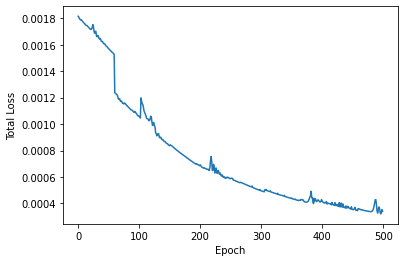

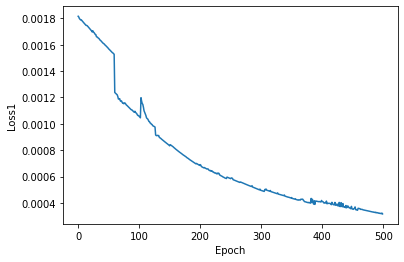

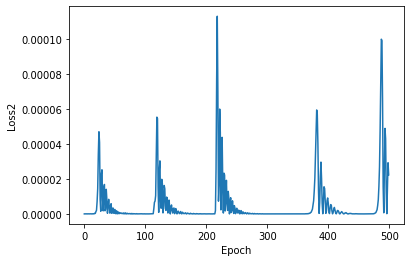

In [ ]:
x_data_plot=[]
y_data_all_plot=[]
y_data_1_plot=[]
y_data_2_plot=[]

# Set fixed random number seed
torch.manual_seed(42)

Epochs = 500
for epoch in range(Epochs):
    # Print epoch
    print(f'Starting epoch {epoch}')
    
    # Set current and total loss value
    current_loss = 0.0
    total_loss = 0.0
    total_loss1 = 0.0
    total_loss2 = 0.0

    for i, data in enumerate(train_loader,0):
        #print(i)

        x_batch, y_batch, temp = data
        print('x batch', x_batch.shape)
        print('temp', temp.shape)
        #if batch_size == 1:
        #  x_batch=torch.squeeze(x_batch)
        #  y_batch=torch.squeeze(y_batch)
        #  delta_t=torch.squeeze(delta_t)
        
        #x_batch = torch.unsqueeze(x_batch, 1)

        #print(x_batch.shape)
        #print(y_batch)
        #print(delta_t)

        # Ground-truth temperature
        #true_temp = x_batch[:,4].detach().clone()

        #input0 = x_batch[0].detach().clone()

        # Predicted temperature using model prediction and forward euler method
        #pred_temp = torch.zeros(x_batch.shape[0])
        #pred_temp[0]=true_temp[0].detach().clone().to(device)

        optimizer.zero_grad()
        #print('x batch0', x_batch.shape)
        #x_batch.requires_grad=True
        x0 = x_batch[:,0,:]
        x =  x_batch[:,1:,:]
        x.requires_grad=True
        u_pred = model(x.to(device))
        print(' x batch 1:', x_batch[:,1:,:])
        print(' x batch 0', x_batch[:,0,:])
        u_t = derivative(x,u_pred)*normalize

        initial = model(x0.to(device))
        #for j in range(0, x_batch.shape[0] - 1):
        #  input0[4] = torch.tensor(pred_temp[j]).detach().clone()
        #  pred = model(input0.to(device))/normalize
        #  pred_temp[j + 1] = pred_temp[j] + pred*delta_t[j]
        print('y batch', y_batch.shape)
        print('y_batch[:,1:,:]', y_batch[:,1:,:])
        loss1 = criterion(u_t.to(device),y_batch[:,1:,:].to(device))
        loss2 = criterion(initial.to(device),temp[:,0, :].to(device))
        #loss = criterion(prediction,y_batch.to(device))
        #loss = criterion(pred_temp.to(device),true_temp.to(device))
        loss = loss1+loss2

        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_loss += loss.item()
        total_loss1 += loss1.item()
        total_loss2 += loss2.item()

        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.8f' %
                  (i + 1, current_loss / 50))
            current_loss = 0.0

    print("Epoch ", epoch, "Total Loss ", total_loss/(i+1))
    print("Epoch ", epoch, "Loss 1 ", total_loss1/(i+1))
    print("Epoch ", epoch, "Loss 2", total_loss2/(i+1))

    x_data_plot.append(epoch)
    y_data_all_plot.append(total_loss/(i+1))
    y_data_1_plot.append(total_loss1/(i+1))
    y_data_2_plot.append(total_loss2/(i+1))

# Make the plot of Total Loss vs epochs
plt.plot(x_data_plot,y_data_all_plot)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.show()

# Make the plot of the supervised loss
plt.plot(x_data_plot,y_data_1_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss1')
plt.show()

# Make the plot of time stability loss
plt.plot(x_data_plot,y_data_2_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss2')
plt.show()

In [ ]:
initial

tensor([[12.9418]], grad_fn=<AddmmBackward>)

In [ ]:
temp[0]

tensor([[12.9466],
        [12.9493],
        [12.9520],
        [12.9546],
        [12.9573],
        [12.9600],
        [12.9627],
        [12.9654],
        [12.9681],
        [12.9708],
        [12.9735]])

In [ ]:
u_t

tensor([[[-5.1422e-02],
         [-2.2218e-02],
         [ 1.2336e-03],
         [ 2.7649e-03],
         [ 8.8072e-04],
         [ 2.9412e-04],
         [ 4.7096e-04],
         [-2.6791e-05],
         [-8.3344e-05],
         [ 8.7011e-04]]], grad_fn=<MulBackward0>)

In [ ]:
y_batch[:,1:,:]

tensor([[[0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002],
         [0.0002]]])

In [ ]:
y_batch.shape

torch.Size([1, 11, 1])

In [ ]:
ds.temp[0]

tensor([12.9466])

In [ ]:
#torch.save(model.state_dict(),  '/content/drive/MyDrive/NeuralSolvers-heat-eqn/examples/Research project/pinnmodel_' + str(normalize) + str(batch_size)+'.pt')

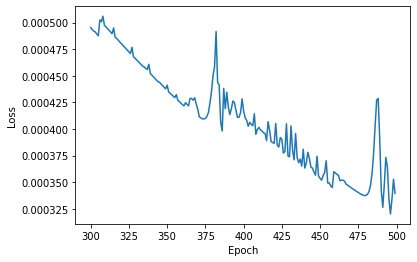

In [ ]:
# Plot of last 100 epochs
plt.plot(x_data_plot[-200:],y_data_all_plot[-200:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot of last 100 epochs
#plt.plot(x_data_plot[-200:],y_data_1_plot[-200:])
#plt.xlabel('Epoch')
#plt.ylabel('Loss 1')
#plt.show()

# Plot of last 100 epochs
#plt.plot(x_data_plot[-200:],y_data_2_plot[-200:])
#plt.xlabel('Epoch')
#plt.ylabel('Loss 2')
#plt.show()

In [ ]:
# Make a prediction
normalize = 1
pred = model(ds.x.float().to(device)) #GPU
pred = pred.detach().cpu().numpy()/normalize

# ground-truth
df_y_tensor_np = ds.temp.numpy()/normalize

In [ ]:
# Some statistics on the model performance on all of dataset
mae = np.sum(np.abs(pred- df_y_tensor_np).mean(axis=None))
print('MAE:', mae)

mse = ((df_y_tensor_np - pred)**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(pred - df_y_tensor_np) / np.linalg.norm(df_y_tensor_np)
print('Relative error (%):', rel_error*100)


MAE: 1.7333786
MSE: 3.6627576
Relative error (%): 14.767204225063324


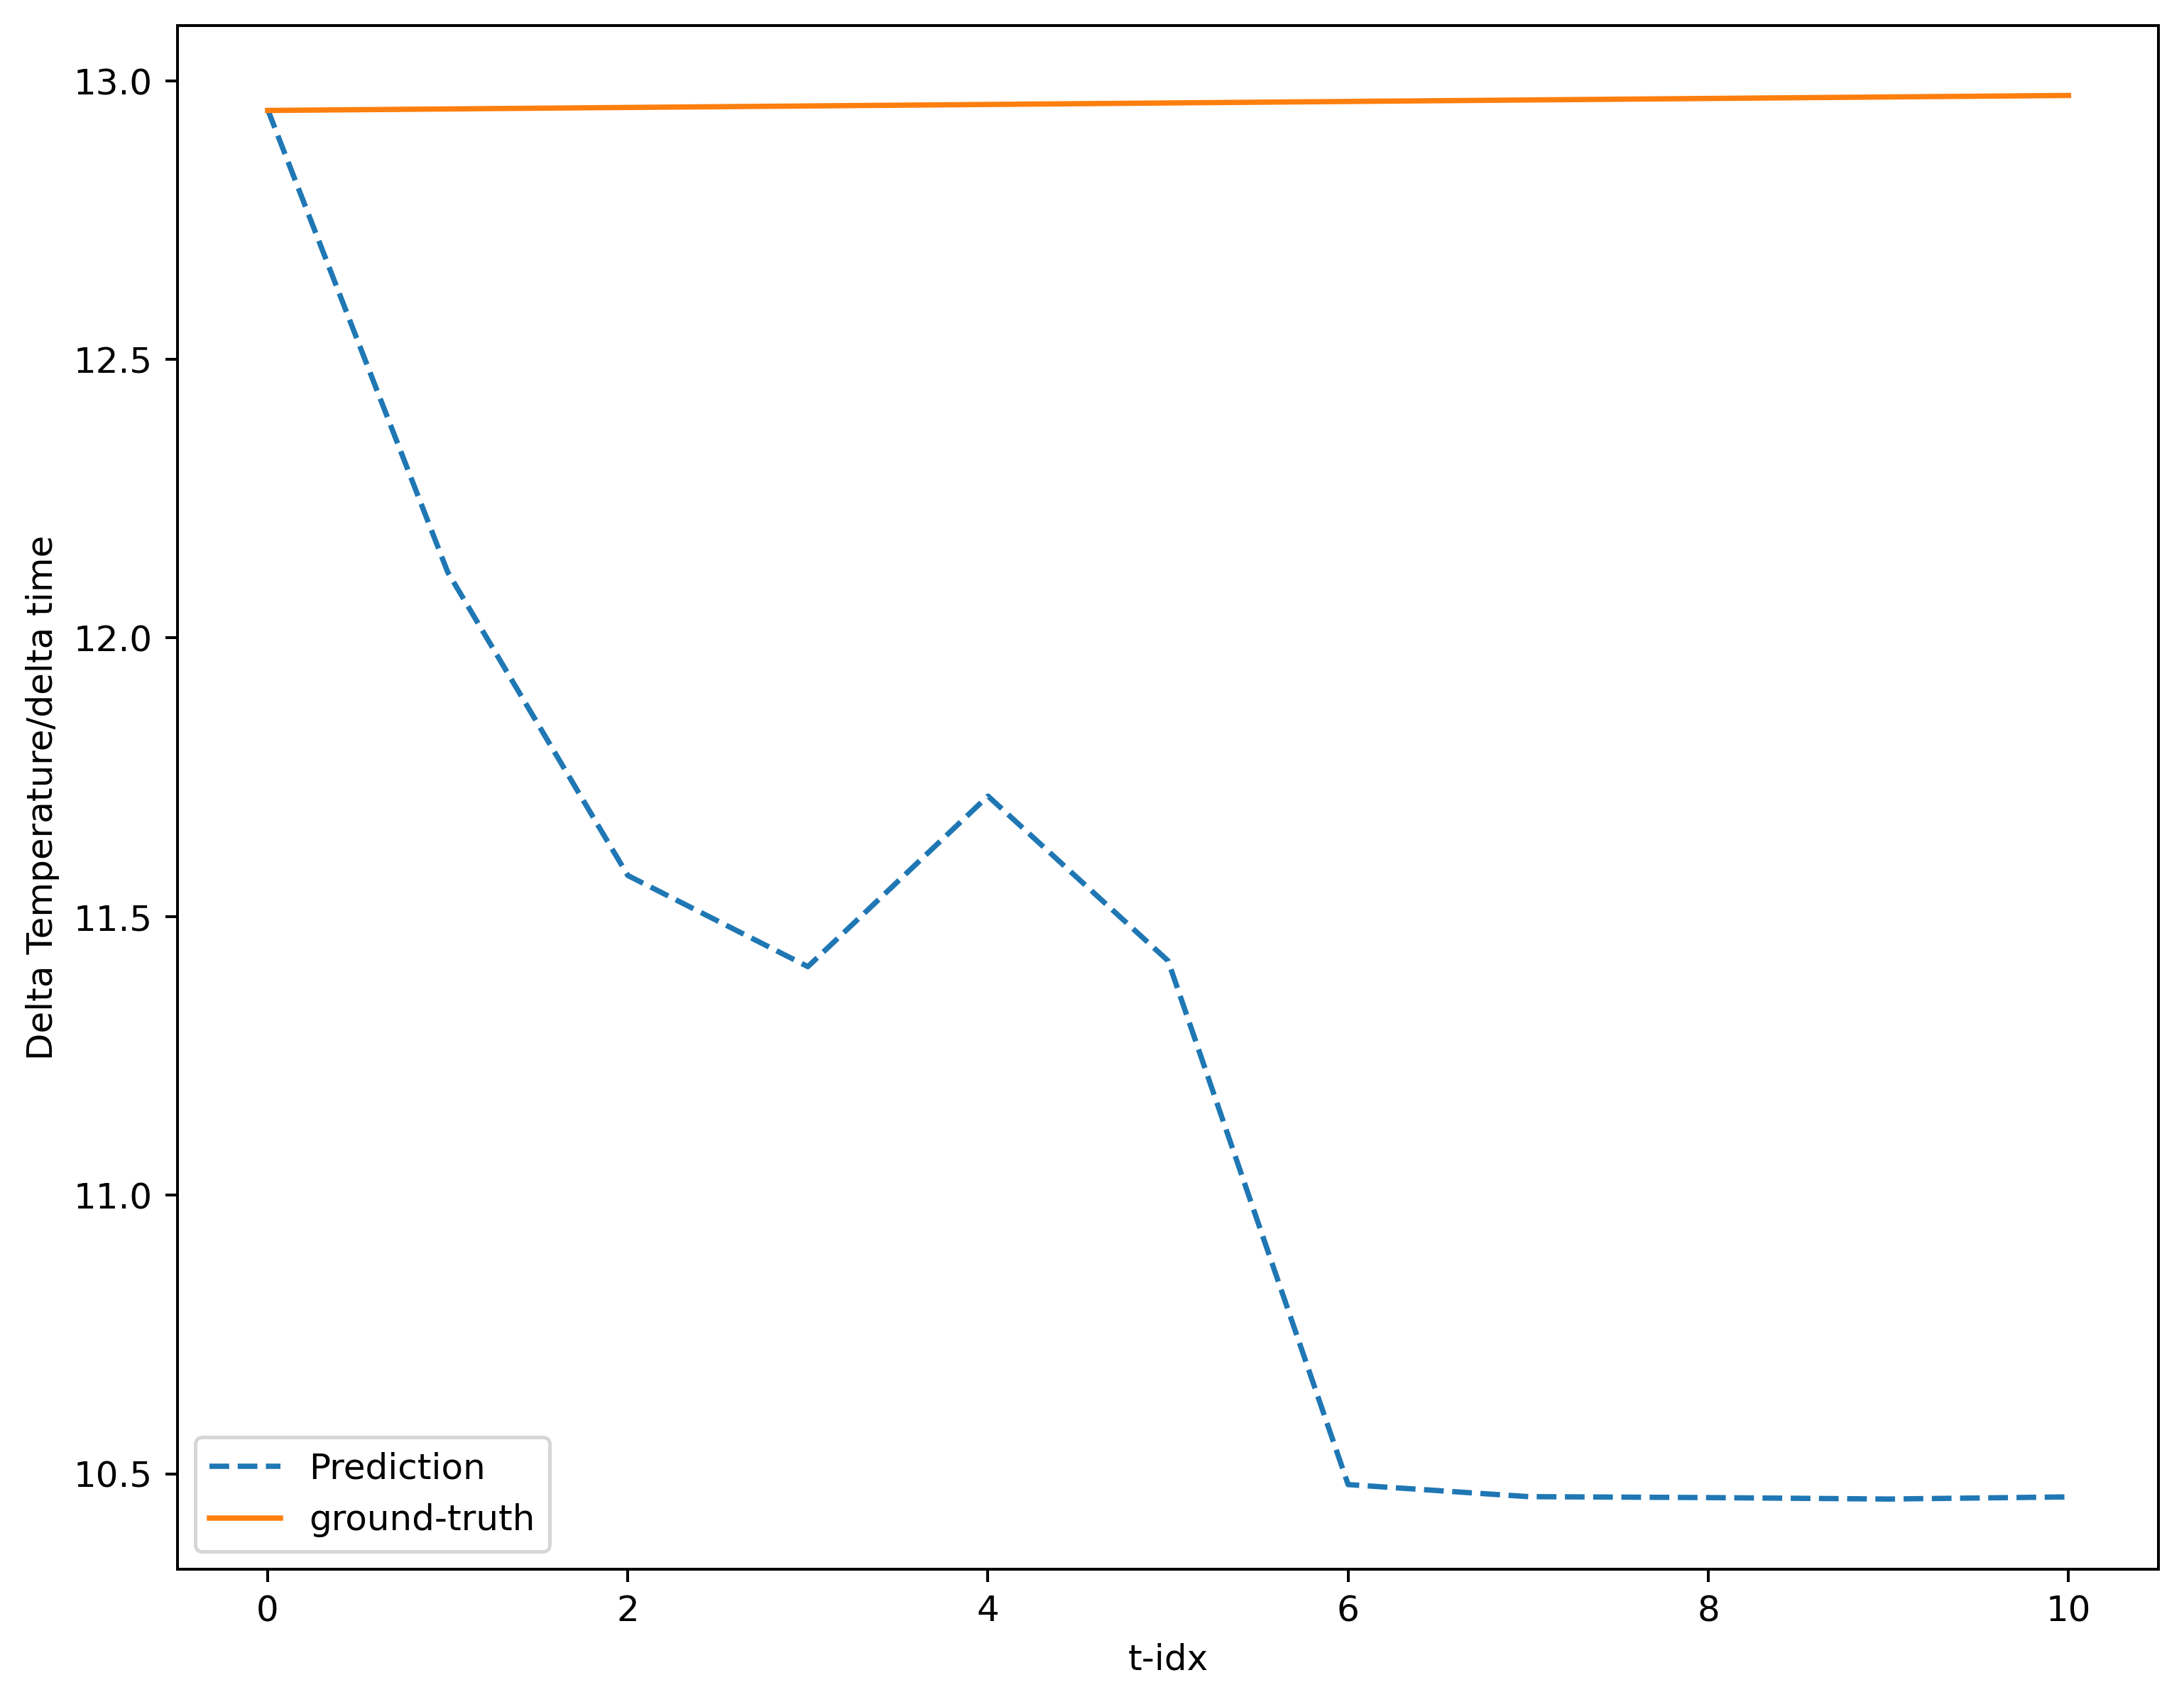

In [ ]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('t-idx')
plt.ylabel('Delta Temperature/delta time')
plt.show()



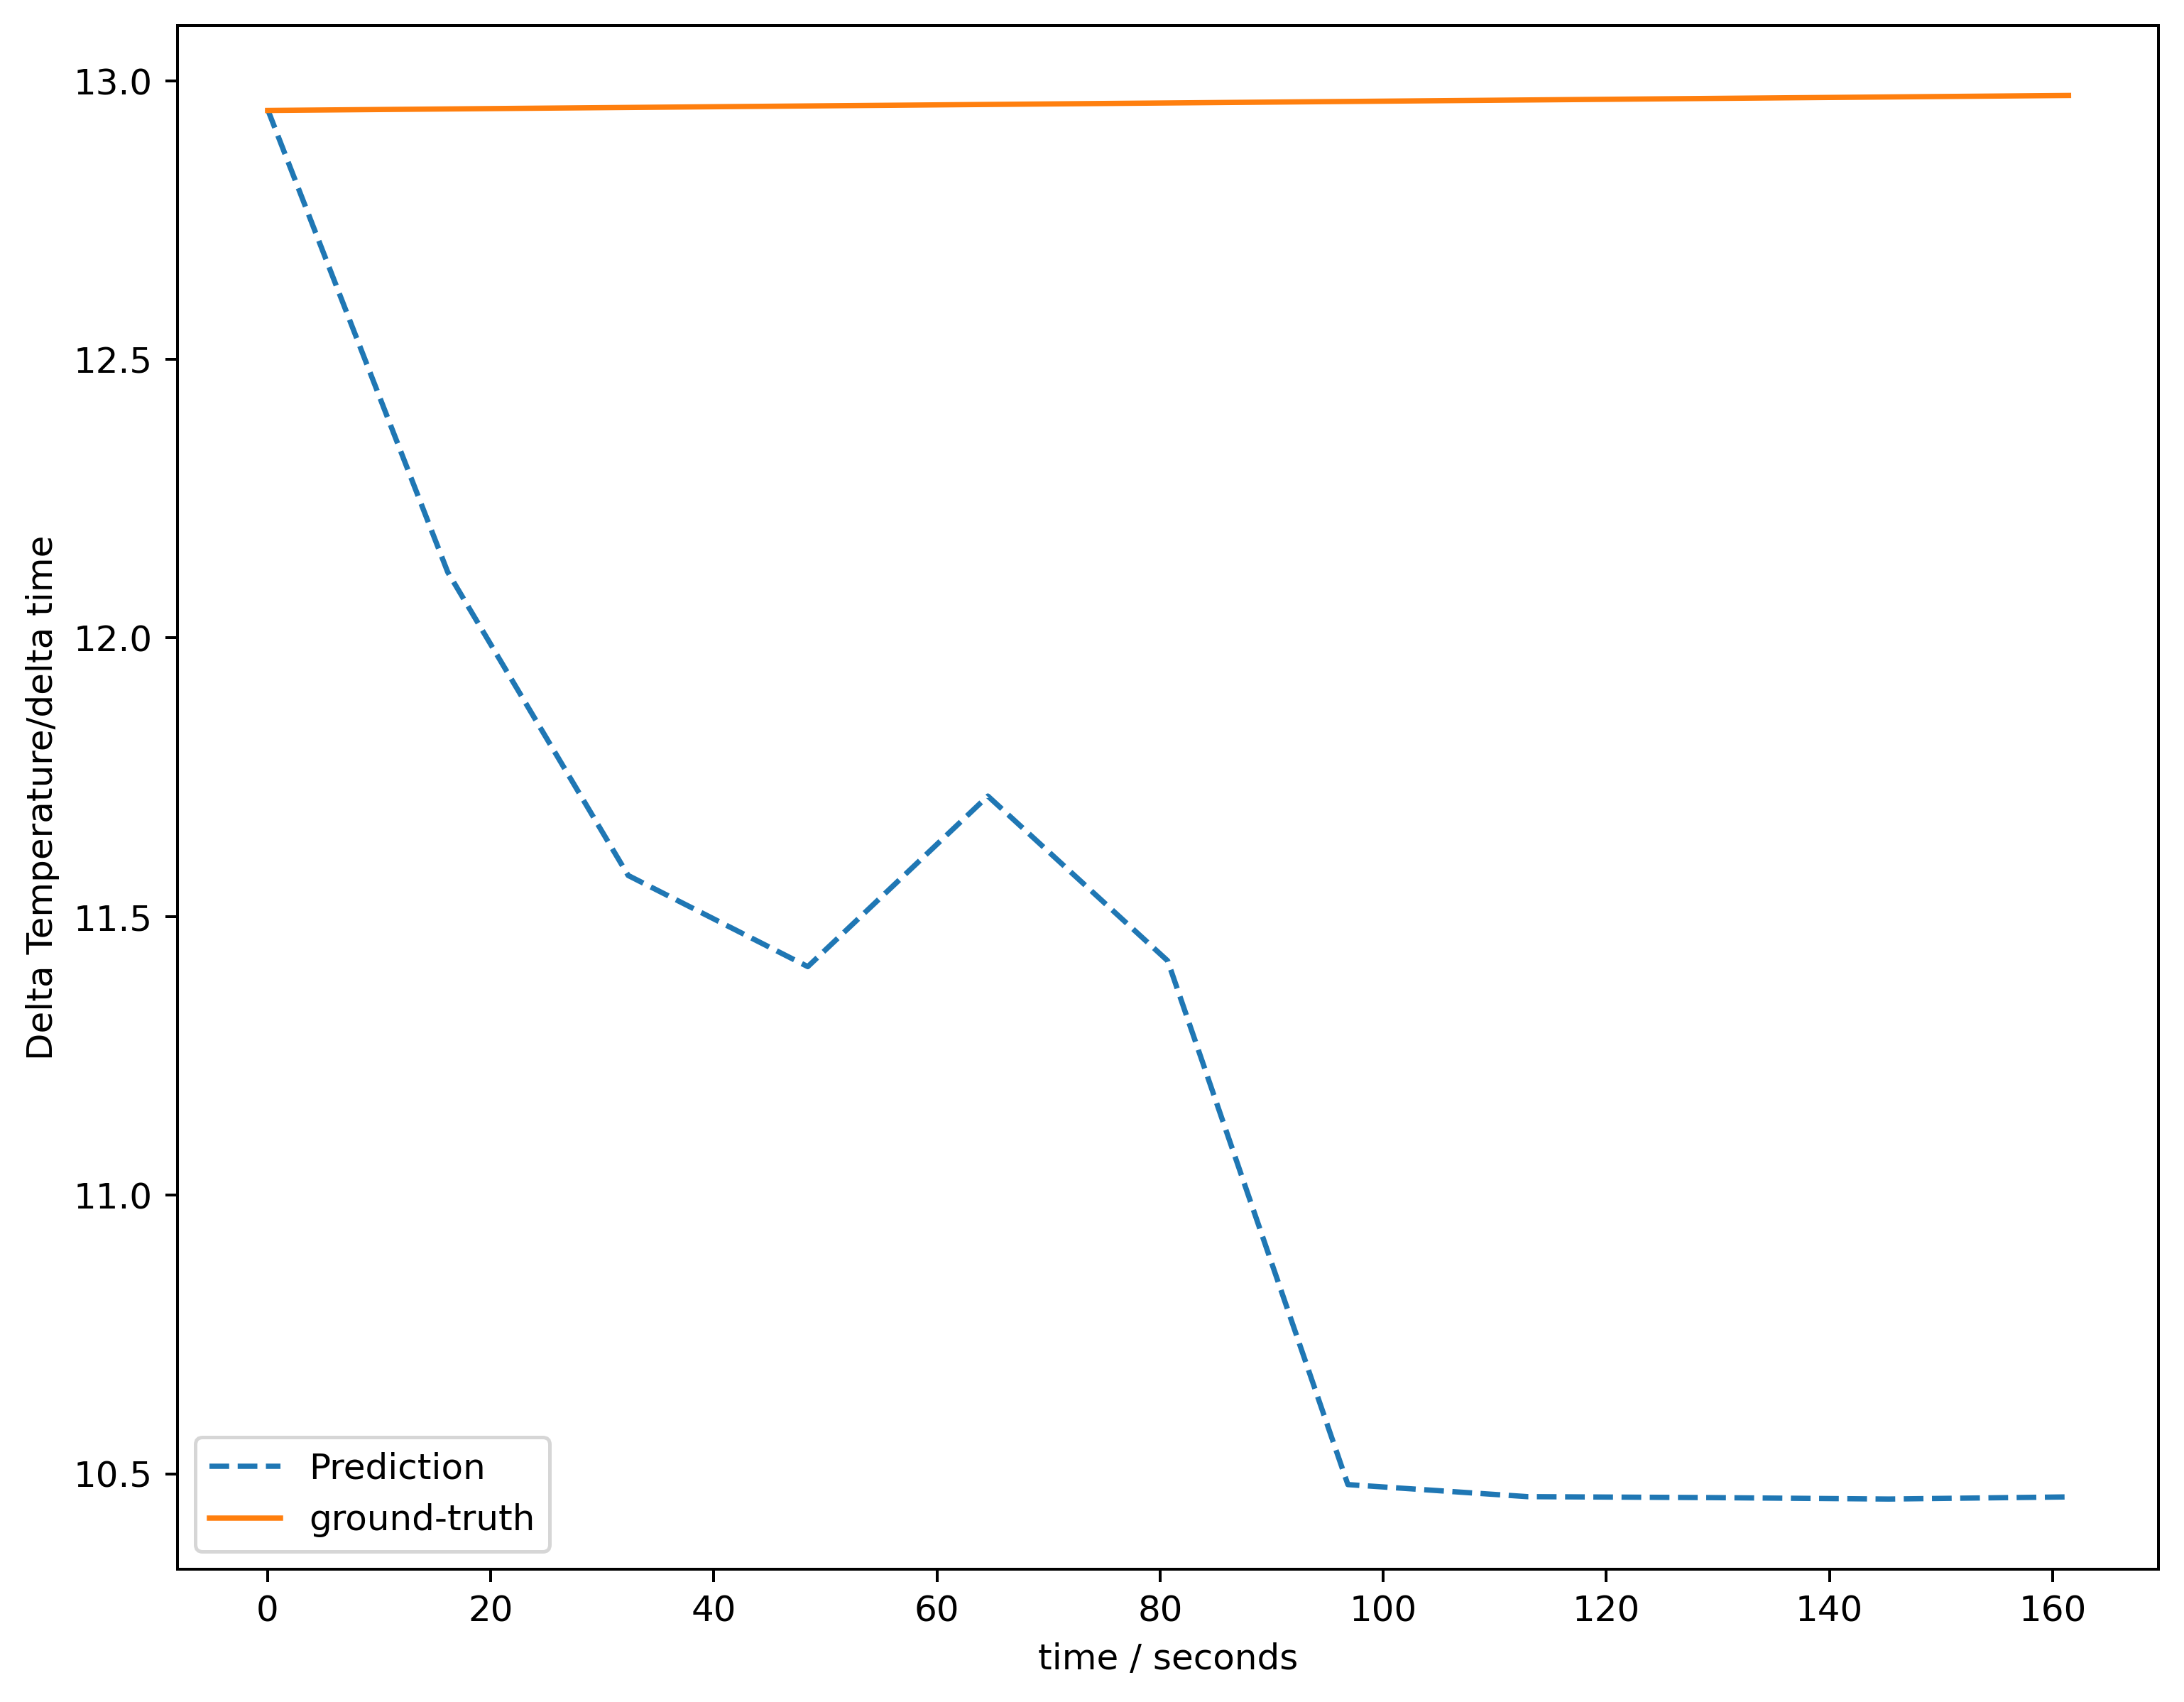

In [ ]:
figure(figsize=(10, 8), dpi= 360)

#time
t=ds.t

plt.plot(t,pred, '--')
plt.plot(t,df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('time / seconds')
plt.ylabel('Delta Temperature/delta time')
plt.show()

In [ ]:
# Import a slice of the datase (based on drive-id) for further analysis
dss = TeslaDatasetpinn(device = device, ID = 0)

(13, 10)
delta ttttt  tensor([[16.1440],
        [16.1770],
        [16.1000],
        [16.1420],
        [16.1180],
        [16.1550],
        [16.0920],
        [16.1510],
        [16.2450],
        [16.1080],
        [16.3470]])


(11, 1)
(11, 1)
MAE: 1.7333786
MSE: 3.6627576
Relative error (%): 14.767204225063324


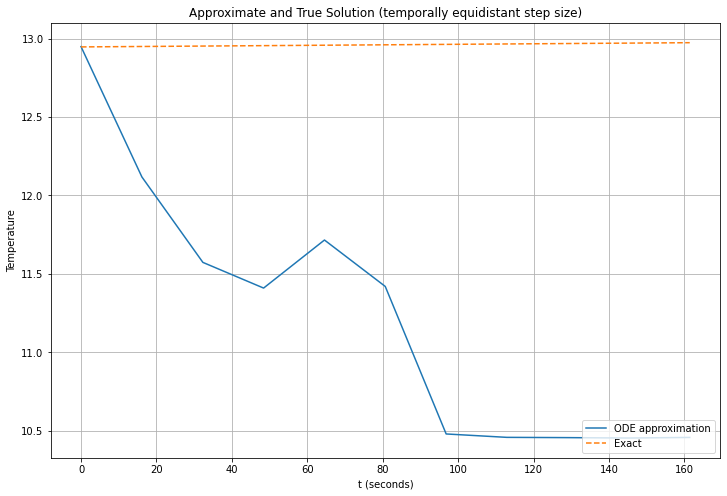

In [ ]:
t = dss.t.numpy()

true_temp = dss.temp.numpy()

pred_temp = model(dss.x.to(device))
pred_temp = pred_temp.detach().cpu().numpy()

print((pred_temp.shape))
print((true_temp.shape))

#MAE
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

#Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(t, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate and True Solution (temporally equidistant step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [ ]:

#model.load_state_dict(torch.load( '/content/drive/MyDrive/NeuralSolvers-heat-eqn/examples/Research project/modelfor_' + str(normalize) + str(batch_size)+'.pt'))